## Evaluation Metrics

### 1. Recap of data preparation, model training and use.

In [1708]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [1709]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [1710]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [1711]:
df = pd.read_csv(data)

In [1712]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [1713]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [1714]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [1715]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [1716]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

### 2. Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [1717]:
len(y_val)

1409

In [1718]:
(y_val == churn_decision).sum()

np.int64(1135)

In [1719]:
from sklearn.metrics import accuracy_score

In [1720]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [1721]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


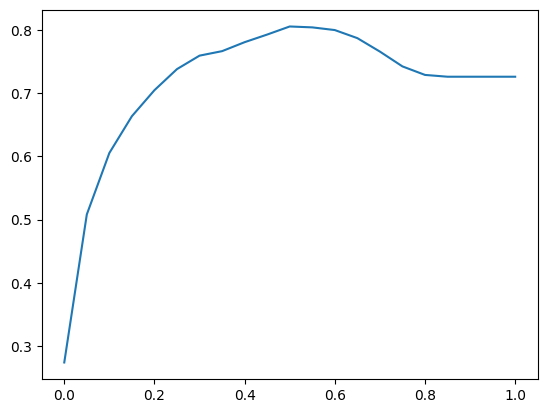

In [1722]:
plt.plot(thresholds, scores)

In [1723]:
from collections import Counter

In [1724]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [1725]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [1726]:
1 - y_val.mean()

np.float64(0.7260468417317246)

##### There is class imbalance

### 3. Confusion table
- Different types of errors and correct deciions
- Arranging them in a table

In [1727]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [1728]:
t= 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [1729]:
predict_positive[:5]

array([False, False, False,  True, False])

In [1730]:
actual_positive[:5]

array([False, False, False,  True, False])

In [1731]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [1732]:
tp, tn

(np.int64(212), np.int64(923))

In [1733]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [1734]:
fp, fn

(np.int64(100), np.int64(174))

In [1735]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]]
)
confusion_matrix

array([[923, 100],
       [174, 212]])

In [1736]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

### 4. Precision and Recall

In [1737]:
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Accuracy

np.float64(0.8055358410220014)

##### Precision is the fraction of positive predictions (customers that are predicted to be churning) are correct

In [1738]:
p = tp / (tp + fp)
p

np.float64(0.6794871794871795)

##### Recall is the fraction of correctly identified positive predictions

In [1739]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

#### In the case of class imbalance, the accuracy can be misleading, therefore precision and recall are the means of verifying the predictive performance of the model 

### 5. ROC Curves [Receiver Operating Characteristics]
True Positive Rate [TPR] and False Positive Rate [FPR]  
The goal of using ROC curves is to maximize true positives rate and minimize false positives rate

In [1740]:
tpr = tp / (tp + fn)
tpr                                     # the same as recall

np.float64(0.5492227979274611)

In [1741]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09775171065493646)

In [1742]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [1743]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [1744]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,367,537,19,486
20,0.2,337,367,49,656
30,0.3,292,245,94,778
40,0.4,252,175,134,848
50,0.5,212,100,174,923
60,0.6,155,51,231,972
70,0.7,69,13,317,1010
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [1745]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp +  df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

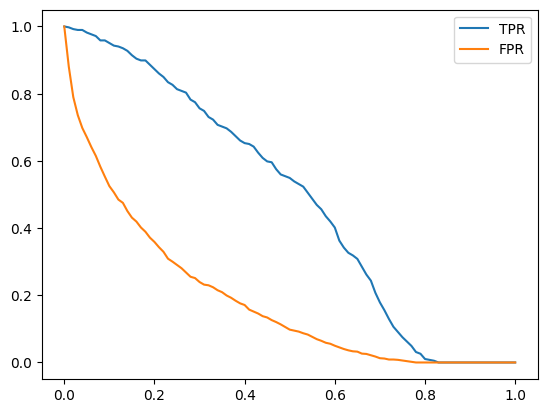

In [1746]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = "TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label = "FPR")
plt.legend()

#### Random Model

In [1747]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [1748]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [1749]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp +  df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return  df_scores

In [1750]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [1751]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


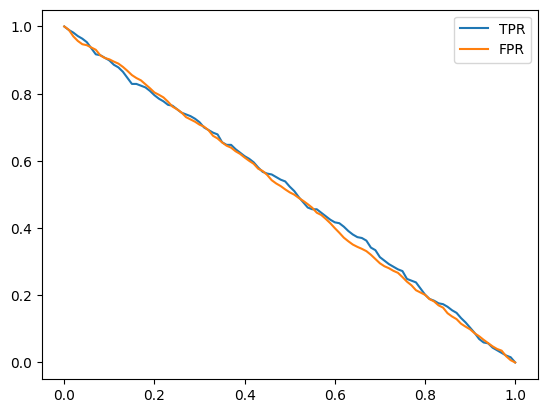

In [1752]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = "TPR")
plt.plot(df_rand.threshold, df_rand['fpr'], label = "FPR")
plt.legend()

#### Ideal model

In [1753]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [1754]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [1755]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [1756]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [1757]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [1758]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [1759]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


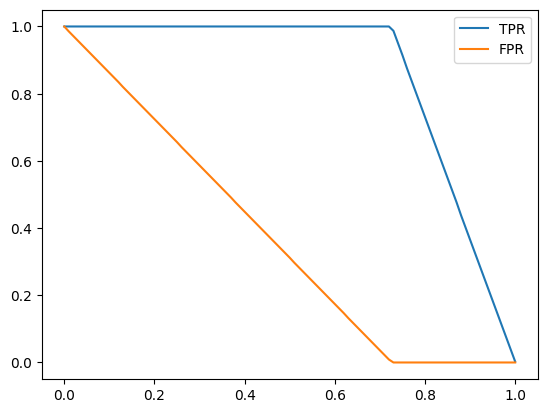

In [1760]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = "TPR")
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = "FPR")
plt.legend()

### Putting everything together

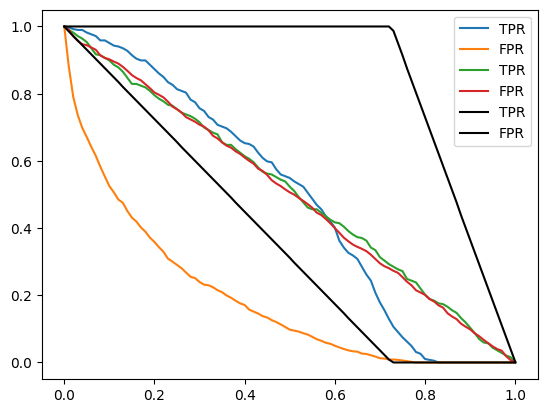

In [1761]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = "TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label = "FPR")

plt.plot(df_rand.threshold, df_rand['tpr'], label = "TPR")
plt.plot(df_rand.threshold, df_rand['fpr'], label = "FPR")

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = "TPR", color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = "FPR", color='black')

plt.legend()

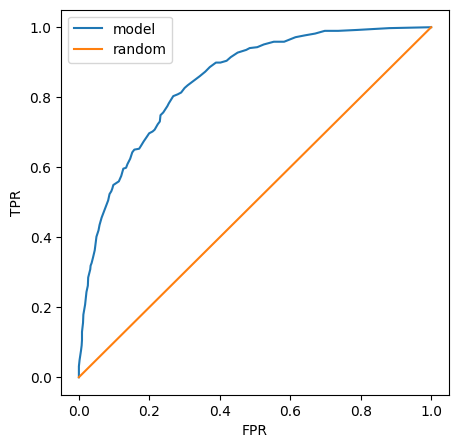

In [1762]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

##### Plotting ROC curve with Scikit-Learn

In [1763]:
from sklearn.metrics import roc_curve

In [1764]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

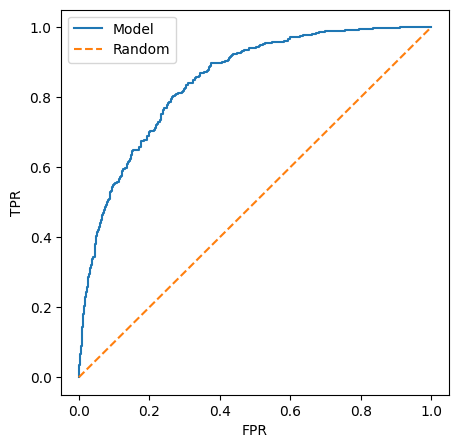

In [1765]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### 6. ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

In [1766]:
from sklearn.metrics import auc

In [1767]:
auc(fpr, tpr)

np.float64(0.8465981898206534)

In [1768]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8463208889834327)

In [1769]:
auc(df_ideal.fpr, df_ideal.tpr)

np.float64(0.9999430203759136)

In [1770]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

np.float64(0.8465981898206534)

In [1771]:
from sklearn.metrics import roc_auc_score

In [1772]:
roc_auc_score(y_val, y_pred)

np.float64(0.8465981898206534)

In [1773]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [1774]:
import random

In [1775]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84769

In [1776]:
n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84796)

##### AUC is popular as a way of measuring the performance of binary classification models

### 7. Cross-Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [1777]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, solver='liblinear', random_state=1, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [1778]:
dv, model = train(df_train, y_train, C=0.001)

In [1779]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [1780]:
y_pred = predict(df_val, dv, model)

In [1781]:
from sklearn.model_selection import KFold

In [1782]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [1783]:
from tqdm.auto import tqdm

In [1784]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    
    scores = []

    for train_idx, val_idx in \
                tqdm(kfold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.churn.values
        y_val = df_val.churn.values    
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]
6it [00:00,  6.69it/s]                                                                                                           
7it [00:01,  6.68it/s]
8it [00:01,  6.24it/s]
9it [00:01,  6.50it/s]
10it [00:01,  6.59it/s]
 14%|█████████████▍                                                                                | 1/7 [00:01<00:09,  1.52s/it]

C=0.001 0.826 +- 0.016



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]
6it [00:00,  6.45it/s]                                                                                                           
7it [00:01,  6.66it/s]
8it [00:01,  6.82it/s]
9it [00:01,  6.92it/s]
10it [00:01,  6.42it/s]
 29%|██████████████████████████▊                                                                   | 2/7 [00:03<00:07,  1.55s/it]

C=0.01 0.840 +- 0.012



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]
6it [00:00,  6.72it/s]                                                                                                           
7it [00:01,  6.46it/s]
8it [00:01,  6.41it/s]
9it [00:01,  6.46it/s]
10it [00:01,  6.59it/s]
 43%|████████████████████████████████████████▎                                                     | 3/7 [00:04<00:06,  1.54s/it]

C=0.1 0.842 +- 0.012



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]
6it [00:00,  6.26it/s]                                                                                                           
7it [00:01,  6.38it/s]
8it [00:01,  6.50it/s]
9it [00:01,  6.39it/s]
10it [00:01,  6.22it/s]
 57%|█████████████████████████████████████████████████████▋                                        | 4/7 [00:06<00:04,  1.57s/it]

C=0.5 0.842 +- 0.012



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]
6it [00:01,  5.67it/s]                                                                                                           
7it [00:01,  5.93it/s]
8it [00:01,  6.16it/s]
9it [00:01,  6.28it/s]
10it [00:01,  6.19it/s]
 71%|███████████████████████████████████████████████████████████████████▏                          | 5/7 [00:07<00:03,  1.58s/it]

C=1 0.842 +- 0.012



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]
6it [00:00,  6.71it/s]                                                                                                           
7it [00:01,  6.77it/s]
8it [00:01,  6.75it/s]
9it [00:01,  6.76it/s]
10it [00:01,  6.67it/s]
 86%|████████████████████████████████████████████████████████████████████████████████▌             | 6/7 [00:09<00:01,  1.56s/it]

C=5 0.842 +- 0.012



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]
6it [00:01,  5.74it/s]                                                                                                           
7it [00:01,  5.86it/s]
8it [00:01,  5.51it/s]
9it [00:01,  5.83it/s]
10it [00:01,  5.79it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.58s/it]

C=10 0.842 +- 0.012


In [1785]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
    
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8579400803839363)

### 8. Summary
- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; something misleading
- Precision and recall are less misleading when we have class imbalance
- ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)

### 9. Explore more
- Check the precision and recall of the dummy classifier
- F1 score = 2 * P * R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way, you'll ge the precision/recall curve (similar to the ROC curve)
- Area under the PR curve is also a useful metric

Other projects:
- Calculate the metrics for datasets from the previous week